In [1]:
import argparse
import os
import random
import shutil
import time
import warnings
import json
import re

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms

from model_analysis_nets import *
from CKA import linear_CKA, kernel_CKA

import numpy as np
import sympy
import pandas
import seaborn

import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, fclusterdata
import scipy
import networkx as nx
import gif

import gudhi as gd
from ripser import Rips

In [2]:
def getGradients(modelpth : str = ""):
    if not modelpth:
        return {}
    model1 = LeNet().to(device)
    model1.load_state_dict(torch.load(modelpth))
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model1.parameters(), lr=0.01, momentum=0.5)

    for X, Y in test_loader:
        X_test = X.to(device)
        Y_test = Y.to(device)
        # print(Y)
        break

    # Forward pass
    outputs = model1(X_test)

    # Compute the loss
    loss = criterion(outputs, Y_test)

    # Zero the gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Access the gradients
    gradients1 = {}
    for name, param in model1.named_parameters():
        gradients1[name] = param.grad
    return gradients1

In [3]:
trans_mnist = transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize((0.1307,), (0.3081,))])
dataset_test = datasets.MNIST('data/mnist/', train=False, download=True, transform=trans_mnist)
test_loader = torch.utils.data.DataLoader(
                dataset_test, batch_size=32,
                num_workers=2, pin_memory=True, shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
attack_pth = "../TDA-NN/3090/LG-FedAvg/save_attack_ub/mnist/lenet_iidTrue_num100_C0.8_le2/shard2/pattern11-30--17-49-20/local_attack_save/"
normal_pth = "../TDA-NN/3090/LG-FedAvg/save_attack_ub/mnist/lenet_iidTrue_num100_C0.8_le2/shard2/pattern11-30--17-49-20/local_normal_save/"

In [5]:
round_set = []
client_set_attack = []
client_set_normal = []
modelpth_set = []
for dirpath, dirnames, filenames in os.walk(attack_pth):
    for filename in filenames:
        # if int(re.findall(r'-?\d+', filename)[0]) < round_max and int(re.findall(r'-?\d+', filename)[1]) < client_max:
        modelpth_set.append(os.path.join(dirpath, filename).replace("\\","/"))
        round_set.append(int(re.findall(r'-?\d+', filename)[0]))
        client_set_attack.append(int(re.findall(r'-?\d+', filename)[1]))

round_set = list(set(round_set))
client_set_attack = list(set(client_set_attack))

for dirpath, dirnames, filenames in os.walk(normal_pth):
    for filename in filenames:
        # if int(re.findall(r'-?\d+', filename)[0]) < round_max and int(re.findall(r'-?\d+', filename)[1]) < client_max:
        modelpth_set.append(os.path.join(dirpath, filename).replace("\\","/"))
        client_set_normal.append(int(re.findall(r'-?\d+', filename)[1]))

client_set_normal = list(set(client_set_normal))

print(round_set, len(round_set))
print(client_set_attack, len(client_set_attack))
print(client_set_normal, len(client_set_normal))
print(len(modelpth_set))


[8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50] 22
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19] 20
[21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60, 63, 66, 69, 72, 75, 78, 81, 84, 87, 90, 93, 96, 99] 27
833


In [6]:
modelpth_dict = {}
for idx, r in enumerate(round_set):
    current_set_normal = []
    current_set_attack = []
    for mt in modelpth_set:
        # print(mt)
        if int(re.findall(r'-?\d+', mt)[-2]) == r and int(re.findall(r'-?\d+', mt)[-1]) in client_set_normal:
            # print(int(re.findall(r'-?\d+', mt)[-1]))
            current_set_normal.append(mt)
        if int(re.findall(r'-?\d+', mt)[-2]) == r and int(re.findall(r'-?\d+', mt)[-1]) in client_set_attack:
            # print(int(re.findall(r'-?\d+', mt)[-1]))
            current_set_attack.append(mt)
        
    modelpth_dict[f'{r}_normal'] = current_set_normal
    modelpth_dict[f'{r}_attack'] = current_set_attack
# print(modelpth_dict)

In [7]:
client_max = 14
corr_set = []
for idx, r in enumerate(round_set):
    if idx > 15:
        break
    r_modelpth_set = modelpth_dict[f'{r}_normal'][0:15] + modelpth_dict[f'{r}_attack'][0:15]
    # print(len(r_modelpth_set))
    r_corr = np.zeros((client_max * 2, client_max * 2, 1))

    gradientlist = []
    for idx, modelp1 in enumerate(r_modelpth_set):
        gradientlist.append(getGradients(modelp1))
    
    for id1, modelp1 in enumerate(gradientlist):
        if id1 >= client_max * 2:
            break
        for id2, modelp2 in enumerate(gradientlist):
            if id2 >= client_max * 2:
                break
            if id2 <= id1:
                continue
            gradients1 = gradientlist[id1]
            gradients2 = gradientlist[id2]
            
            corrlist = []

            acts1 = gradients1["layer3.0.weight"]
            acts2 = gradients2["layer3.0.weight"]
            acts1 = acts1.cpu().reshape((50,-1))
            acts2 = acts2.cpu().reshape((50,-1))
            l = linear_CKA(acts1.T, acts2.T)
            k = kernel_CKA(acts1.T, acts2.T)
            corrlist.append((l+k)/2)

            r_corr[id1][id2] = np.array(corrlist)
    corr_set.append(r_corr)

print(len(corr_set))

16


0 0.15849199512770906 0.20503059196909978 set()
1 0.16570926611630443 0.1859854878231868 {25, 27, 21}
2 0.07440518779341398 0.07533588321971041 {0, 9, 11}
3 0.0 inf {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27}
4 0.0 0.18628089909290302 {18, 20}
5 0.0 0.15767802743773407 {17, 25}
6 0.0 0.1464803589213347 {16, 24}
7 0.0 0.1357047638713328 {21, 23}
8 0.0 0.13110019680628682 {17, 26}
9 0.0 0.12137554366074566 {17, 27}
10 0.0 0.12122116428865182 {1, 19}
11 0.0 0.09722612051139601 {27, 23}
12 0.0 0.09145980529430686 {1, 2}
13 0.0 0.07929121286219432 {0, 8, 9, 11, 20, 26}
14 0.0 0.07769103933473143 {4, 12}
15 0.0 0.0706996564895932 {0, 1}
16 0.0 0.07047794164252541 {8, 10}
17 0.0 0.0703839008710212 {11, 15}
18 0.0 0.06883810725922057 {8, 9}
19 0.0 0.06736501387020255 {26, 19}
20 0.0 0.06667039427475785 {16, 26}
21 0.0 0.06305502401773744 {11, 12}
22 0.0 0.05494566360974773 {0, 8}
23 0.0 0.052635023100906286 {27, 22}
24 0.0 0.0491456918

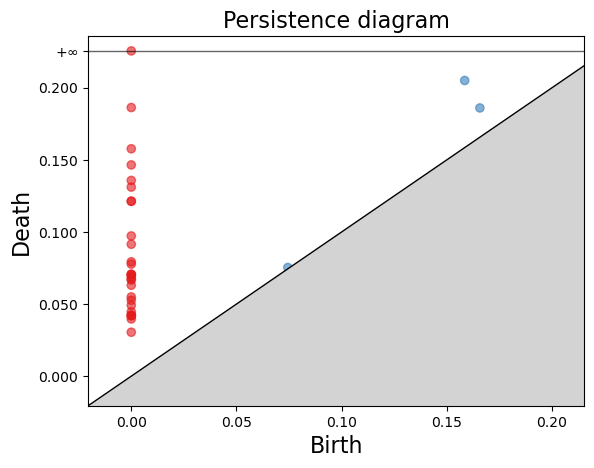

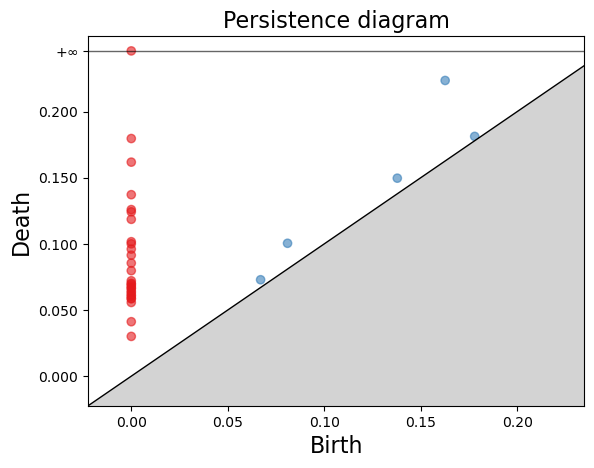

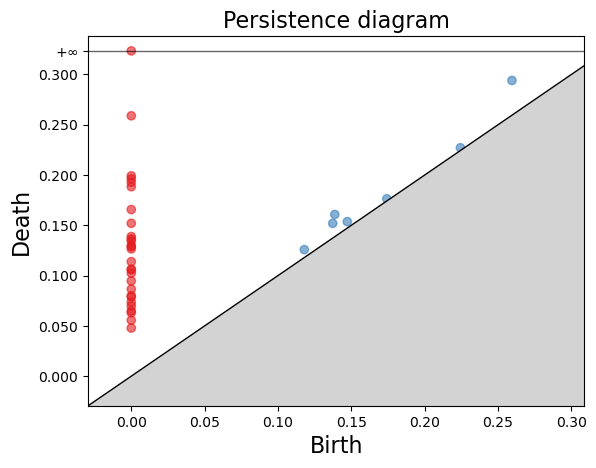

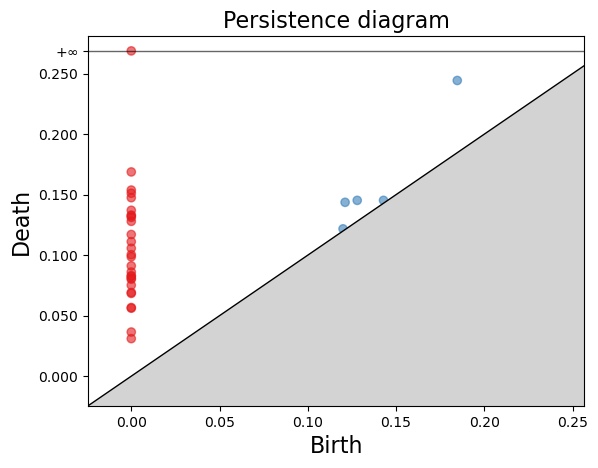

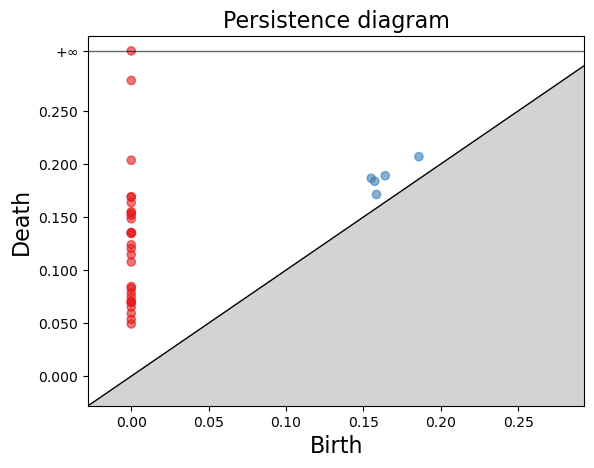

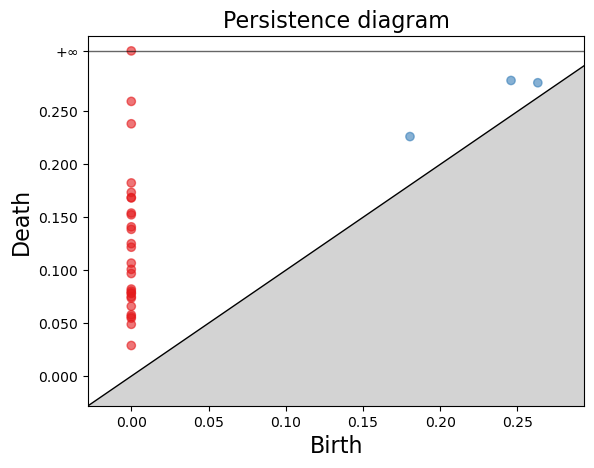

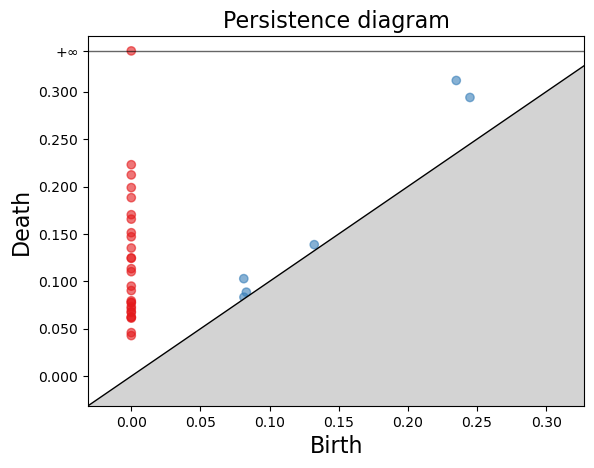

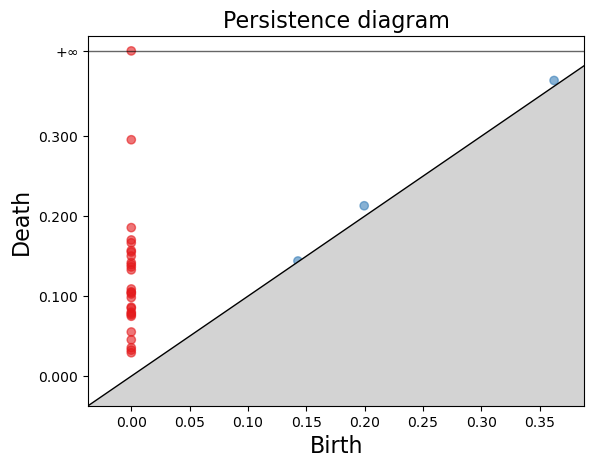

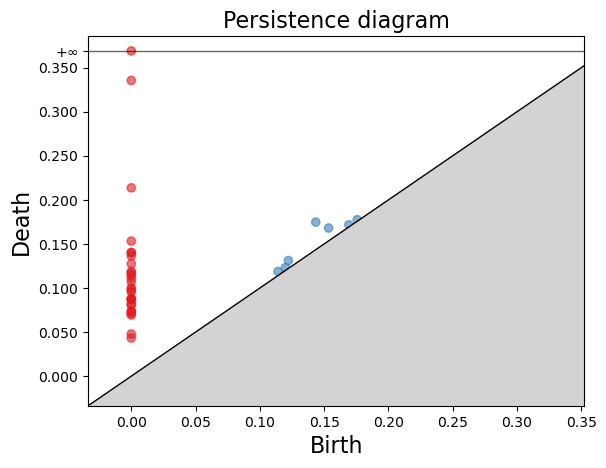

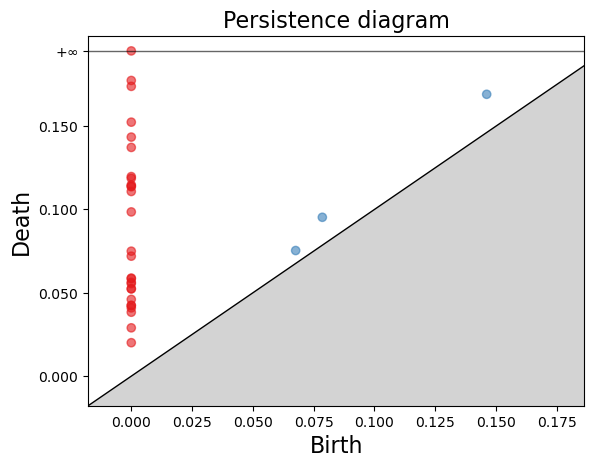

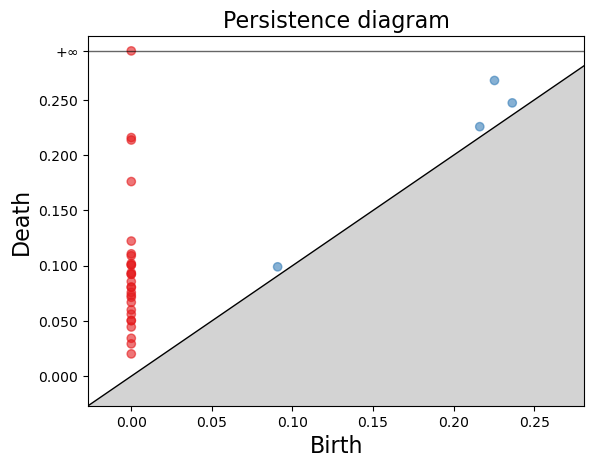

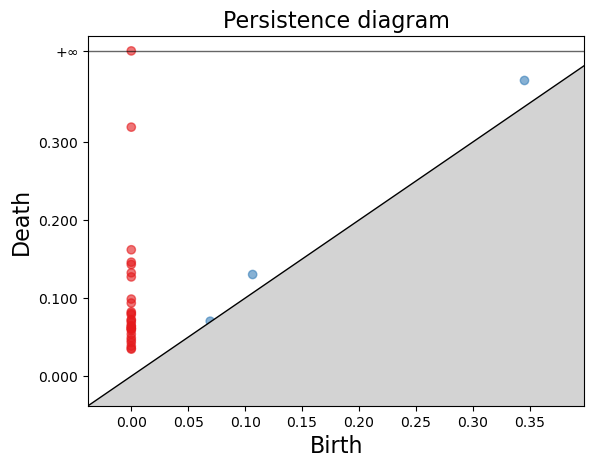

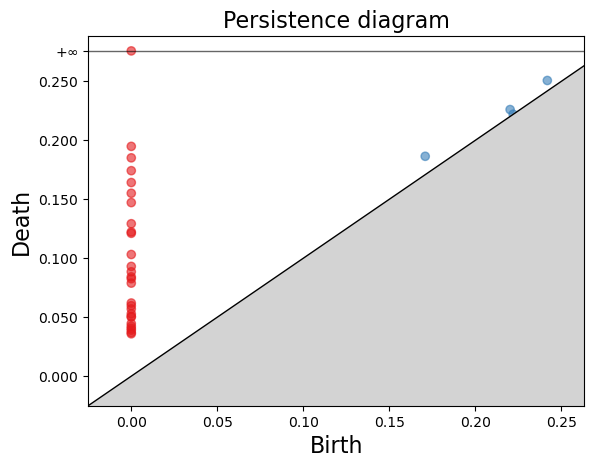

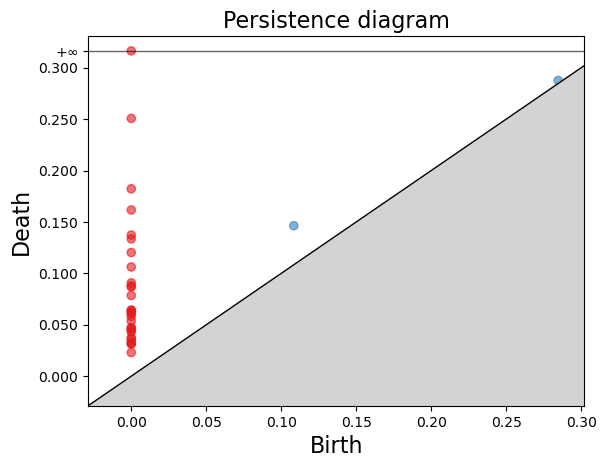

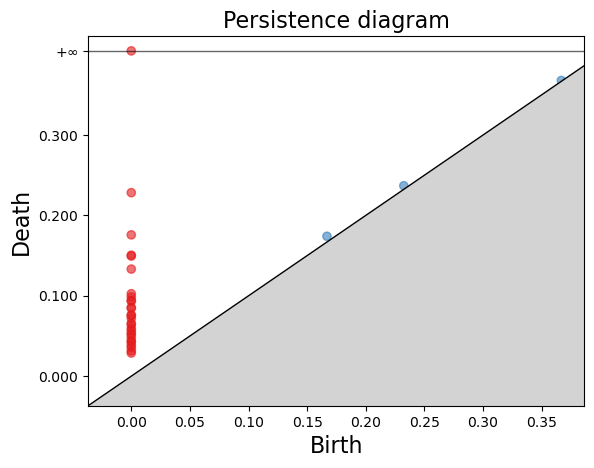

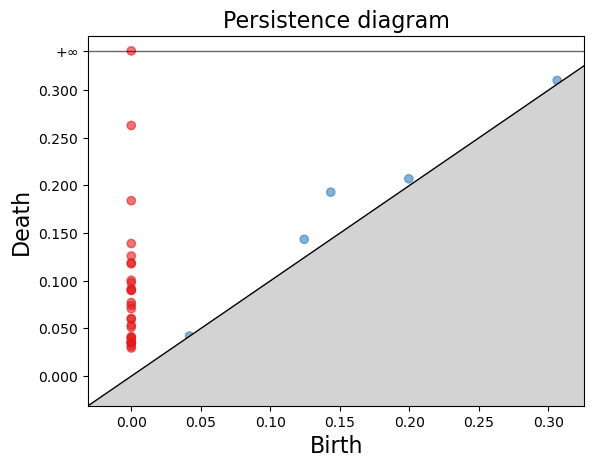

In [32]:
for corr in corr_set:
    # print(1 - corr.reshape(-1, 2 * client_max) - corr.reshape(-1, 2 * client_max).T)

    data = 1 - corr.reshape(-1, 2 * client_max) - corr.reshape(-1, 2 * client_max).T
    rips_complex = gd.RipsComplex(distance_matrix=data, max_edge_length=2)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    persistence = simplex_tree.persistence()

    gd.plot_persistence_diagram(persistence=persistence)
    pairs = simplex_tree.persistence_pairs()
    filtration = simplex_tree.get_filtration()

    count = 0
    for birth_value, death_value in [i[1] for i in persistence if (i[0] == 1 or i[0] == 0)]:
        filtration = simplex_tree.get_filtration()
        tolerance = 1e-5
        birth_simplices = []
        death_simplices = []

        for simplex, filtration_value in filtration:
            # print(filtration_value, birth_value)
            if abs(filtration_value - birth_value) < tolerance:
                # print(simplex)
                birth_simplices.append(simplex)
            elif abs(filtration_value - death_value) < tolerance or (death_value == np.Inf):
                death_simplices.append(simplex)
        # print(birth_simplices)

        involved_points = set()

        for birth_simplex in birth_simplices:
            for death_simplex in death_simplices:
                if set(birth_simplex).issubset(death_simplex):
                    involved_points.update(birth_simplex)
                    involved_points.update(death_simplex)

        if len(involved_points) >= 0 : print(count, birth_value, death_value, involved_points) 
        count += 1
    print()

In [25]:
for corr in corr_set:
    print(1 - corr.reshape(-1, 2 * client_max) - corr.reshape(-1, 2 * client_max).T)

    data = 1 - corr.reshape(-1, 2 * client_max) - corr.reshape(-1, 2 * client_max).T
    rips_complex = gd.RipsComplex(distance_matrix=data,max_edge_length=1)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=1)
    result_str = 'Rips complex is of dimension ' + repr(simplex_tree.dimension()) + ' - ' + \
        repr(simplex_tree.num_simplices()) + ' simplices - ' + \
        repr(simplex_tree.num_vertices()) + ' vertices.'
    print(result_str)
    fmt = '%s -> %.2f'
    for filtered_value in simplex_tree.get_filtration():
        print(fmt % tuple(filtered_value))


[[1.         0.07069966 0.11861293 0.16772022 0.13567774 0.14596807
  0.08928912 0.15087281 0.05494566 0.07533588 0.08167419 0.07440519
  0.0915501  0.19290037 0.04230498 0.10280824 0.33276276 0.21314372
  0.48729729 0.14586425 0.18285559 0.41551279 0.29697368 0.31778981
  0.49866712 0.29799269 0.2225882  0.2622273 ]
 [0.07069966 1.         0.09145981 0.2555342  0.214456   0.1010593
  0.14354016 0.1217403  0.07582865 0.12016743 0.07825601 0.15523677
  0.17842263 0.28365152 0.08410292 0.15132059 0.25673748 0.17760403
  0.4278624  0.12122116 0.13093047 0.31499043 0.23047856 0.2611969
  0.43316411 0.23434576 0.16218991 0.19834369]
 [0.11861293 0.09145981 1.         0.2091929  0.2079575  0.04460677
  0.14603197 0.05089962 0.1394515  0.13740192 0.20873539 0.21501825
  0.1802652  0.2208159  0.13187221 0.21510917 0.23149033 0.28699666
  0.42059579 0.1664677  0.21789198 0.33129627 0.32776414 0.38484863
  0.4107217  0.26435029 0.21882211 0.32813775]
 [0.16772022 0.2555342  0.2091929  1.        